In [1]:
!pip -q install stable-baselines3 simglucose

In [160]:
import os
import time
import numpy as np
from pathlib import Path
from datetime import datetime
from typing import Any, Tuple, Dict

import gymnasium as gym
from gymnasium import Wrapper, ActionWrapper
from gymnasium.envs.registration import register
from stable_baselines3 import DQN, PPO, SAC, TD3
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.callbacks import EvalCallback, BaseCallback
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.noise import NormalActionNoise

import matplotlib.pyplot as plt
from IPython.display import clear_output
import imageio

In [170]:
register(
    id="simglucose-adol1-v0",
    entry_point="simglucose.envs:T1DSimGymnaisumEnv",
    max_episode_steps=288,
    kwargs={
        "patient_name": "adolescent#001",
    },
)

register(
    id="simglucose-adol2-v0",
    entry_point="simglucose.envs:T1DSimGymnaisumEnv",
    max_episode_steps=288,
    kwargs={
        "patient_name": "adolescent#002",
    },
)

/usr/local/lib/python3.11/dist-packages/gymnasium/envs/registration.py:694: UserWarning: WARN: Overriding environment simglucose-adol1-v0 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")
/usr/local/lib/python3.11/dist-packages/gymnasium/envs/registration.py:694: UserWarning: WARN: Overriding environment simglucose-adol2-v0 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")


In [171]:
def plot_navie(pid):
  # 환경 생성
  env = gym.make(pid)
  obs, info = env.reset(seed=42)

  # 혈당 수치 기록
  bg_levels = [info["bg"]]
  steps = env.spec.max_episode_steps if env.spec and env.spec.max_episode_steps else 288

  # 인슐린 투여 없이 시뮬레이션
  for _ in range(steps):
      action = np.array([0.0])  # 인슐린 0 IU
      obs, reward, done, truncated, info = env.step(action)
      bg_levels.append(info["bg"])
      if done or truncated:
          break

  env.close()

  # 그래프 그리기
  plt.figure(figsize=(8, 3))
  plt.plot(bg_levels, marker='o')
  plt.title("Baseline BG Trajectory (Insulin=0)")
  plt.xlabel("Timestep (5 min)")
  plt.ylabel("BG (mg/dL)")
  plt.grid(True)
  plt.show()

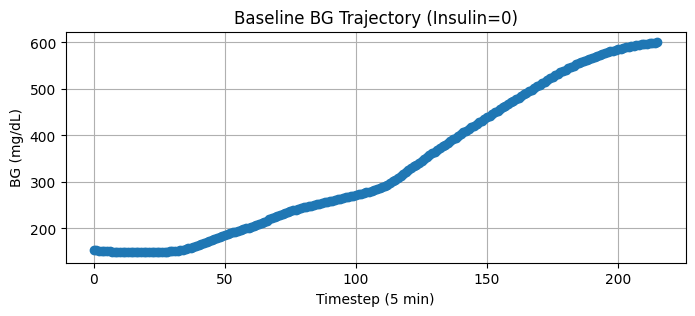

In [172]:
ENV_ID = "simglucose-adol1-v0"
plot_navie(ENV_ID)

In [173]:
# Configuration constants
SAC_TOTAL_TIMESTEPS = 100_000

# (SAC) Reward wrapper hyperparameters
SAC_DEFAULT_SCALE_RISK = 0.1
SAC_DEFAULT_LAMBDA_INS = 0.2
SAC_DEFAULT_HYPO1 = 70
SAC_DEFAULT_HYPO2 = 60
SAC_DEFAULT_HYPER = 250

# (SAC) Safety filter hyperparameters
SAC_DEFAULT_SAFETY_SCALE = 0.5
SAC_DEFAULT_SAFETY_CUTOFF = 80

In [174]:
class SACGymCompat(Wrapper):
    """
    (SAC) Gym 환경이 SB3 호환 5-튜플을 반환하도록 보장
    """
    def step(self, action: Any) -> Tuple[Any, float, bool, bool, dict]:
        result = self.env.step(action)
        if len(result) == 5:
            return result  # type: ignore
        obs, reward, done, info = result
        return obs, reward, done, False, info

    def reset(self, **kwargs) -> Tuple[Any, dict]:
        result = self.env.reset(**kwargs)
        if isinstance(result, tuple) and len(result) == 2:
            return result
        return result, {}

class SACRiskDeltaPen(Wrapper):
    """
    (SAC) 보상 = scale_risk*(prev_risk - current_risk)
             - lambda_insulin*|action|
             + TIR 보너스 또는 저/고혈당 패널티
    """
    def __init__(
        self,
        env: gym.Env,
        scale_risk: float = SAC_DEFAULT_SCALE_RISK,
        lambda_ins: float = SAC_DEFAULT_LAMBDA_INS,
        hypo1: float = SAC_DEFAULT_HYPO1,
        hypo2: float = SAC_DEFAULT_HYPO2,
        hyper: float = SAC_DEFAULT_HYPER
    ):
        super().__init__(env)
        self.scale_risk = scale_risk
        self.lambda_ins = lambda_ins
        self.h1, self.h2, self.H = hypo1, hypo2, hyper
        self.prev_risk: float = 0.0

    @staticmethod
    def _risk(bg: float) -> float:
        f = 1.509 * ((np.log(bg)) ** 1.084 - 5.381)
        return 10 * (f ** 2)

    def reset(self, **kwargs) -> Tuple[Any, dict]:
        obs, info = self.env.reset(**kwargs)
        self.prev_risk = self._risk(info.get("bg", 100.0))
        return obs, info

    def step(self, action: Any) -> Tuple[Any, float, bool, bool, dict]:
        obs, _, done, truncated, info = self.env.step(action)
        bg = info.get("bg", 100.0)
        current_risk = self._risk(bg)

        reward = self.scale_risk * (self.prev_risk - current_risk)
        ins_amount = float(np.abs(np.asarray(action).item()))
        reward -= self.lambda_ins * ins_amount

        if bg < self.h2:
            reward -= 10.0
        elif bg < self.h1:
            reward -= 5.0
        elif bg > self.H:
            reward -= 2.0
        else:
            reward += 10.0

        self.prev_risk = current_risk
        return obs, float(reward), done, truncated, info

class SACSafetyFilter(ActionWrapper):
    """
    (SAC) 혈당이 cutoff 이하일 때 행동 스케일 조정
    """
    def __init__(
        self,
        env: gym.Env,
        scale: float = SAC_DEFAULT_SAFETY_SCALE,
        cutoff: float = SAC_DEFAULT_SAFETY_CUTOFF
    ):
        super().__init__(env)
        self.scale = scale
        self.cutoff = cutoff
        self._last_info: dict = {}

    def action(self, action: Any) -> Any:
        bg = self._last_info.get("bg", None)
        if bg is not None and bg < self.cutoff:
            return np.asarray(action) * self.scale
        return action

    def step(self, action: Any) -> Tuple[Any, float, bool, bool, dict]:
        obs, reward, done, truncated, info = self.env.step(action)
        self._last_info = info
        return obs, reward, done, truncated, info

    def reset(self, **kwargs) -> Tuple[Any, dict]:
        obs, info = self.env.reset(**kwargs)
        self._last_info = info
        return obs, info

class SACRewardLogger(BaseCallback):
    """
    (SAC) 에피소드 리턴과 타임스텝을 기록하는 콜백
    """
    def __init__(self):
        super().__init__(verbose=0)
        self.timesteps: list[int] = []
        self.returns: list[float] = []

    def _on_step(self) -> bool:
        for info in self.locals.get("infos", []):
            ep = info.get("episode")
            if ep:
                self.timesteps.append(self.num_timesteps)
                self.returns.append(float(ep.get("r", 0.0)))
        return True

def sac_make_env() -> gym.Env:
    env = gym.make(ENV_ID)
    env = SACGymCompat(env)
    env = SACRiskDeltaPen(env)
    env = SACSafetyFilter(env)
    env = Monitor(env)
    return env

def sac_train(total_timesteps: int = SAC_TOTAL_TIMESTEPS) -> Tuple[SAC, SACRewardLogger]:
    """
    (SAC) 구성된 환경에서 SAC 모델을 학습
    학습된 모델과 SACRewardLogger 콜백을 반환
    """
    env = DummyVecEnv([sac_make_env])
    model = SAC(
        policy="MlpPolicy",
        env=env,
        learning_rate=3e-4,
        batch_size=256,
        buffer_size=500_000,
        tau=0.005,
        gamma=0.99,
        ent_coef="auto_0.1",
        verbose=1
    )
    callback = SACRewardLogger()

    print(f"[SAC] 학습 시작: {total_timesteps:,} 타임스텝")
    start_time = time.time()
    model.learn(total_timesteps=total_timesteps, callback=callback, progress_bar=True)
    elapsed = time.time() - start_time
    mean_last_100 = np.mean(callback.returns[-100:]) if len(callback.returns) >= 100 else 0.0
    print(f"학습 완료: {elapsed:.1f}s, 최근 100 에피소드 평균 리턴: {mean_last_100:.2f}")

    return model, callback

Output()

Using cpu device
[SAC] 학습 시작: 100,000 타임스텝
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 125      |
|    ep_rew_mean     | -767     |
| time/              |          |
|    episodes        | 4        |
|    fps             | 15       |
|    time_elapsed    | 32       |
|    total_timesteps | 500      |
| train/             |          |
|    actor_loss      | 22.9     |
|    critic_loss     | 57.1     |
|    ent_coef        | 0.116    |
|    ent_coef_loss   | 19.7     |
|    learning_rate   | 0.0003   |
|    n_updates       | 399      |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 168      |
|    ep_rew_mean     | -473     |
| time/              |          |
|    episodes        | 8        |
|    fps             | 18       |
|    time_elapsed    | 71       |
|    total_timesteps | 1344     |
| train/             |          |
|    actor_loss      | 39.9     |
|    

학습 완료: 5920.9s, 최근 100 에피소드 평균 리턴: -597.53


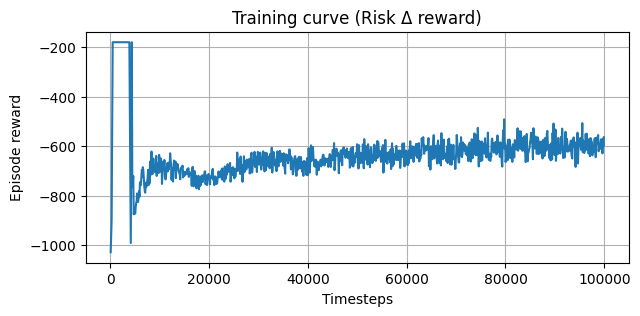

In [175]:
sac_model, sac_log = sac_train(100_000)

# 학습 곡선 시각화
plt.figure(figsize=(7, 3))
plt.plot(sac_log.timesteps, sac_log.returns)
plt.title("Training curve (Risk Δ reward)")
plt.xlabel("Timesteps")
plt.ylabel("Episode reward")
plt.grid(True)
plt.show()

In [176]:
# ----------------------------------------------------------
# 5. 평가 + 시각화 + Metrics 계산
# ----------------------------------------------------------
def compute_metrics_sac(model: SAC, n_episodes: int = 20) -> Dict[str, float]:
    tir_count = 0
    tir_total = 0
    all_lbgi, all_hbgi = [], []

    for ep in range(n_episodes):
        env = sac_make_env()
        obs, info = env.reset(seed=42)
        lbgi_vals, hbgi_vals = [], []
        done = False

        while not done:
            action, _ = model.predict(obs, deterministic=True)
            obs, _, terminated, truncated, info = env.step(action)
            done = terminated or truncated

            bg = info["bg"]
            fbg = 1.509 * ((np.log(bg)) ** 1.084 - 5.381)
            rbg = 10 * (fbg ** 2)
            (lbgi_vals if fbg < 0 else hbgi_vals).append(rbg)

            tir_total += 1
            if 70 <= bg <= 180:
                tir_count += 1

        env.close()
        all_lbgi.append(np.mean(lbgi_vals) if lbgi_vals else 0)
        all_hbgi.append(np.mean(hbgi_vals) if hbgi_vals else 0)

    return {
        "Time-in-Range (%)": 100 * tir_count / tir_total if tir_total else 0,
        "LBGI (mean)": float(np.mean(all_lbgi)),
        "HBGI (mean)": float(np.mean(all_hbgi)),
    }

def evaluate_and_plot_sac(model: SAC, ep_len: int = 288, n_eval_episodes: int = 20) -> Dict[str, float]:
    # 1) SB3 evaluate
    eval_env = DummyVecEnv([sac_make_env])
    mean_r, std_r = evaluate_policy(model, eval_env, n_eval_episodes, deterministic=True)
    print(f"Eval {n_eval_episodes} eps: {mean_r:.2f} ± {std_r:.2f}")

    # 2) 직접 메트릭 계산
    metrics = compute_metrics_sac(model, n_episodes=n_eval_episodes)
    for k, v in metrics.items():
        print(f"{k}: {v:.2f}")
    print()

    # 3) 단일 에피소드 시각화
    env = sac_make_env()
    obs, info = env.reset(seed=42)
    bg_traj, ins_traj = [], []
    for _ in range(ep_len):
        action, _ = model.predict(obs, deterministic=True)
        ins_traj.append(float(np.array(action).ravel()[0]))
        bg_traj.append(info["bg"])
        obs, _, term, trunc, info = env.step(action)
        if term or trunc:
            break
    env.close()

    fig, ax = plt.subplots(2, 1, figsize=(9, 4), sharex=True)
    ax[0].plot(bg_traj, marker='o')  ; ax[0].set_ylabel("BG (mg/dL)"); ax[0].grid(True)
    ax[1].plot(ins_traj, marker='o'); ax[1].set_ylabel("Insulin (IU)"); ax[1].grid(True)
    ax[1].set_xlabel("Timestep (5 min)")
    plt.suptitle("BG & Insulin trajectory")
    plt.tight_layout()
    plt.show()

    return metrics

Eval 20 eps: -156.98 ± 0.00
Time-in-Range (%): 61.09
LBGI (mean): 52.39
HBGI (mean): 1.94



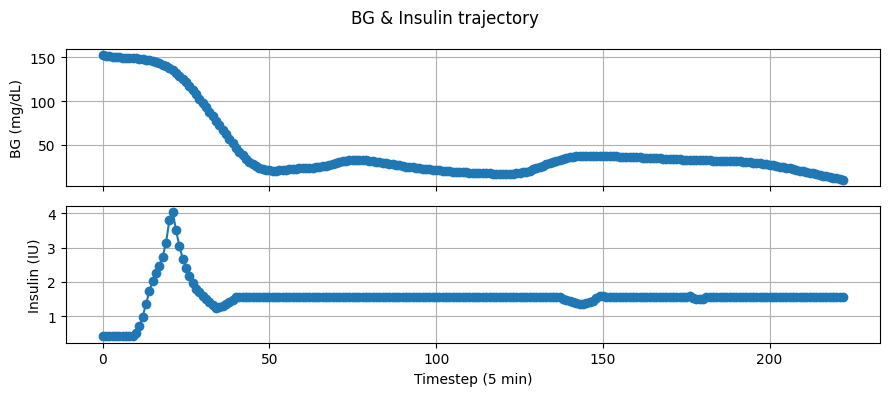

In [177]:
metrics = evaluate_and_plot_sac(sac_model)

In [178]:
# Configuration constants
PPO_TOTAL_TIMESTEPS = 150_000

# (PPO) Reward wrapper hyperparameters
PPO_DEFAULT_LAMBDA_INS = 0.1

In [179]:
class PPORiskReward(Wrapper):
    """
    (PPO) Risk 감소 - 인슐린 페널티 + 저/고혈당 패널티 보상 함수
    """
    def __init__(self, env: gym.Env, lamda: float = PPO_DEFAULT_LAMBDA_INS):
        super().__init__(env)
        self.lamda = lamda
        self.prev_risk = 0.0

    @staticmethod
    def _risk(bg: float) -> float:
        f = 1.509 * ((np.log(bg)) ** 1.084 - 5.381)
        return 10 * (f ** 2)

    def reset(self, **kwargs) -> Tuple[Any, dict]:
        obs, info = self.env.reset(**kwargs)
        self.prev_risk = self._risk(info["bg"])
        return obs, info

    def step(self, action: Any) -> Tuple[Any, float, bool, bool, dict]:
        obs, _, done, truncated, info = self.env.step(action)
        arr = np.asarray(action)
        insulin = arr.ravel()[0].item()

        bg = info["bg"]
        curr_risk = self._risk(bg)

        reward = (self.prev_risk - curr_risk) - self.lamda * abs(float(insulin))
        if bg < 70:
            reward -= 5.0
        elif bg > 250:
            reward -= 2.0
        self.prev_risk = curr_risk

        return obs, float(reward), done, truncated, info

class PPOTrainLogger(BaseCallback):
    """
    (PPO) 에피소드 리턴 및 타임스텝 기록 콜백
    """
    def __init__(self):
        super().__init__(verbose=0)
        self.timesteps: list[int] = []
        self.returns: list[float] = []

    def _on_step(self) -> bool:
        for info in self.locals.get("infos", []):
            ep = info.get("episode")
            if ep:
                self.timesteps.append(self.num_timesteps)
                self.returns.append(float(ep.get("r", 0.0)))
        return True

def make_env_ppo() -> gym.Env:
    env = gym.make(ENV_ID)
    env = PPORiskReward(env)
    env = Monitor(env)
    return env

def train_ppo(total_timesteps: int = PPO_TOTAL_TIMESTEPS) -> Tuple[PPO, PPOTrainLogger]:
    """
    (PPO) MlpPolicy로 PPO 모델 학습
    학습된 모델과 PPOTrainLogger 반환
    """
    env = DummyVecEnv([make_env_ppo])
    model = PPO(
        policy="MlpPolicy",
        env=env,
        learning_rate=3e-4,
        n_steps=2048,
        batch_size=256,
        gamma=0.99,
        gae_lambda=0.95,
        verbose=1
    )
    logger = PPOTrainLogger()

    print(f"[PPO] 학습 시작: {total_timesteps:,} 타임스텝")
    start = time.time()
    model.learn(total_timesteps=total_timesteps, callback=logger, progress_bar=True)
    elapsed = time.time() - start
    mean_last_100 = np.mean(logger.returns[-100:]) if len(logger.returns) >= 100 else 0.0
    print(f"학습 완료: {elapsed:.1f}s, 최근 100 에피소드 평균 리턴: {mean_last_100:.2f}")

    return model, logger

Output()

Using cpu device
[PPO] 학습 시작: 150,000 타임스텝
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 140      |
|    ep_rew_mean     | -700     |
| time/              |          |
|    fps             | 66       |
|    iterations      | 1        |
|    time_elapsed    | 30       |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 140         |
|    ep_rew_mean          | -686        |
| time/                   |             |
|    fps                  | 67          |
|    iterations           | 2           |
|    time_elapsed         | 61          |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.003859399 |
|    clip_fraction        | 0.0133      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.42       |
|    explained_variance   | 0

학습 완료: 2063.2s, 최근 100 에피소드 평균 리턴: -299.57


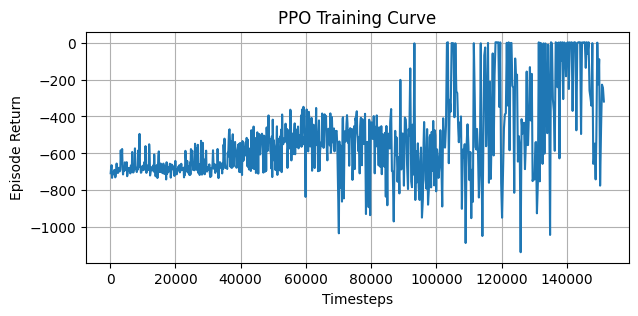

In [180]:
ppo_model, ppo_log = train_ppo(150_000)
# 학습 곡선
plt.figure(figsize=(7, 3))
plt.plot(ppo_log.timesteps, ppo_log.returns)
plt.title("PPO Training Curve")
plt.xlabel("Timesteps"); plt.ylabel("Episode Return"); plt.grid(True)
plt.show()

In [181]:
def compute_metrics_ppo(model: PPO, n_episodes: int = 20) -> Dict[str, float]:
    """
    Time-in-Range, LBGI, HBGI 계산
    """
    tir_count = 0
    tir_total = 0
    all_lbgi, all_hbgi = [], []

    for ep in range(n_episodes):
        env = make_env_ppo()
        obs, info = env.reset(seed=ep)
        lbgi_vals, hbgi_vals = [], []
        done = False

        while not done:
            action, _ = model.predict(obs, deterministic=True)
            obs, _, term, trunc, info = env.step(action)
            done = term or trunc

            bg = info["bg"]
            fbg = 1.509 * ((np.log(bg)) ** 1.084 - 5.381)
            rbg = 10 * (fbg ** 2)
            (lbgi_vals if fbg < 0 else hbgi_vals).append(rbg)

            tir_total += 1
            if 70 <= bg <= 180:
                tir_count += 1

        env.close()
        all_lbgi.append(np.mean(lbgi_vals) if lbgi_vals else 0)
        all_hbgi.append(np.mean(hbgi_vals) if hbgi_vals else 0)

    return {
        "Time-in-Range (%)": 100 * tir_count / tir_total if tir_total else 0,
        "LBGI (mean)": float(np.mean(all_lbgi)),
        "HBGI (mean)": float(np.mean(all_hbgi)),
    }

def evaluate_and_plot_ppo(model: PPO, n_eval: int = 20, ep_len: int = 288) -> Dict[str, float]:
    """
    평가 + 시각화 + Metrics 계산
    """
    # 1) SB3 evaluate
    eval_env = DummyVecEnv([make_env_ppo])
    mean_r, std_r = evaluate_policy(model, eval_env, n_eval, deterministic=True)
    print(f"Eval {n_eval} eps: {mean_r:.2f} ± {std_r:.2f}")

    # 2) 직접 메트릭 계산
    metrics = compute_metrics_ppo(model, n_episodes=n_eval)
    for k, v in metrics.items():
        print(f"{k}: {v:.2f}")
    print()

    # 3) 단일 에피소드 시각화
    env = make_env_ppo()
    obs, info = env.reset(seed=0)
    bg_traj, ins_traj = [], []
    for _ in range(ep_len):
        action, _ = model.predict(obs, deterministic=True)
        ins_traj.append(float(np.array(action).ravel()[0].item()))
        bg_traj.append(info["bg"])
        obs, _, term, trunc, info = env.step(action)
        if term or trunc:
            break
    env.close()

    fig, ax = plt.subplots(2, 1, figsize=(9, 4), sharex=True)
    ax[0].plot(bg_traj, marker='o')  ; ax[0].set_ylabel("BG (mg/dL)"); ax[0].grid(True)
    ax[1].plot(ins_traj, marker='o'); ax[1].set_ylabel("Insulin (IU)"); ax[1].grid(True)
    ax[1].set_xlabel("Timestep (5 min)")
    plt.suptitle("BG & Insulin trajectory")
    plt.tight_layout()
    plt.show()

    return metrics

Eval 20 eps: -477.04 ± 0.00
Time-in-Range (%): 22.72
LBGI (mean): 0.00
HBGI (mean): 33.39



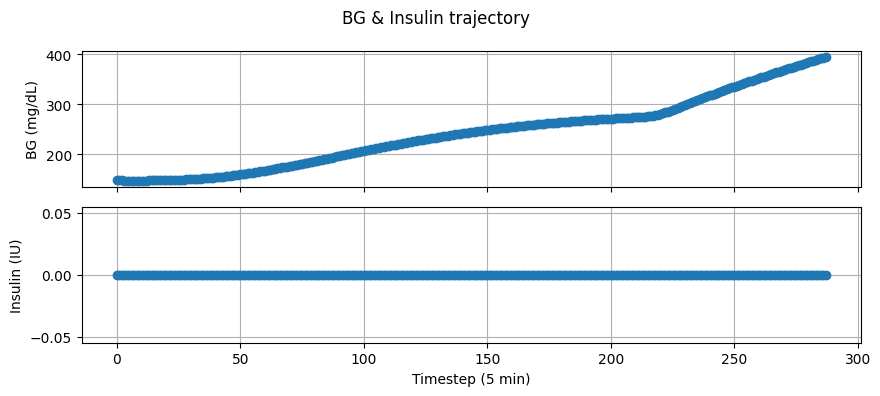

{'Time-in-Range (%)': 22.720848056537104,
 'LBGI (mean)': 0.0,
 'HBGI (mean)': 33.386881405619626}